# One Pixel Attack Tutorial
## Part 1 - Cifar10

### Dan Kondratyuk
### September 15, 2019

![](images/pred2.png "All it takes is one pixel")

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

To read more about it, see [the original paper](https://arxiv.org/abs/1710.08864), or the authors' [official repo](https://github.com/Carina02/One-Pixel-Attack).

Let's get started.

## Imports

Ensure that you have `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu`, and `keras` installed.

Alternatively, you may [run this notebook in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7). Note: colab allows you to run this notebook on GPU, free of charge. Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [ ]:
# Anything above 2.10 is not supported on the GPU on Windows Native
#!pip install "tensorflow<2.11" 

In [ ]:
#!pip install tensorflow-gpu==2.10 --user

In [1]:
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
tf.test.is_gpu_available()

1 Physical GPUs, 1 Logical GPUs
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [18]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Hyperparticle/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras

# Python Libraries
%matplotlib inline
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K
from PIL import Image

# Custom Networks
from networks.lenet import LeNet
from networks.resnet import ResNet
#from networks.pure_cnn import PureCnn
#from networks.network_in_network import NetworkInNetwork
#from networks.densenet import DenseNet
#from networks.wide_resnet import WideResNet
#from networks.capsnet import CapsNet

# Helper functions
from utills.differential_evolution import differential_evolution
from utills import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
len(x_train)

50000

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can access and display any image in the dataset by its index. For instance, here is a horse.

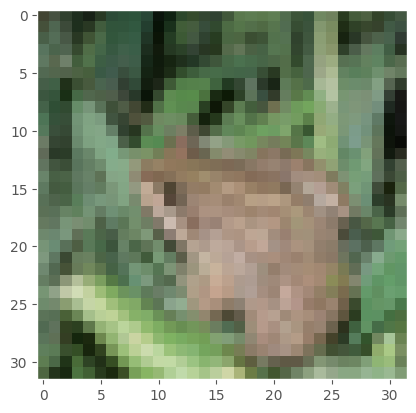

In [5]:
image_id = 4 # Image index in the test set
helper.plot_image(x_test[image_id])

## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. Then multiple perturbations can simply be a concatenation of these tuples:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

We could instead use an array of tuples, but the optimization algorithm we will use requires it to be a flat 1-d vector.

Then the function to perturb an image can take as an input the image and $X$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$. To speed up computation, we will batch together an array of $X$ perturbations, denoted $X_S$.

In [6]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

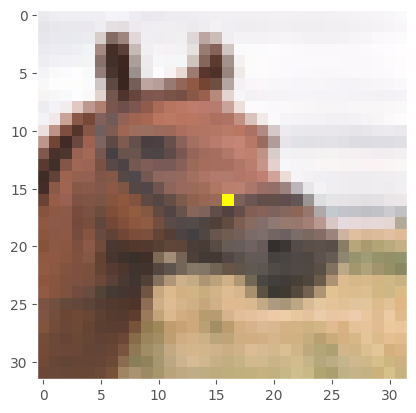

In [7]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]


helper.plot_image(image_perturbed)

## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset. We will now load some pretrained models, which can be found in the `networks/models` directory.

It is recommended to use Keras with a GPU enabled. If you're [running in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7), you can enable a GPU instance by selecting `Runtime > Change runtime type > Hardware accelerator > GPU` (you will need to re-run all cells). The code below can be used to check (if using TensorFlow).

In [8]:
lenet = LeNet()
resnet = ResNet()

models = [resnet]

Successfully loaded lenet
Successfully loaded resnet


In [9]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating resnet


,name,accuracy,param_count
0,resnet,0.9231,470218


### Predict function

In [10]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

Confidence in true class bird is 0.00018887446
Prior confidence was 0.7066173


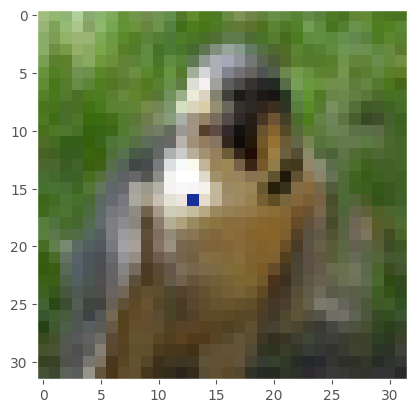

In [11]:
image_id = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

# Attack

### Success Criterion

In [12]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

Here we demonstrate the usage of the success criterion function. It's nearly identical to `predict_class()` as before, but also decides the success of the attack. For purposes of demonstration we assume an untargeted attack.

Confidence: 0.07460088
Prior confidence 0.5005427
Attack success: True


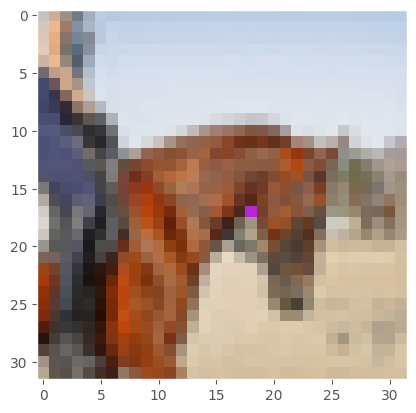

In [13]:
image_id = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

### Attack Function

Finally, we arrive at the attack itself: how do we find the pixels that will result in a successful attack? First, formulate it as an optimization problem: in an untargeted attack, minimize the confidence of the correct class, and in a targeted attack, maximize the confidence of a target class. This is precisely our `predict_class` function.

When performing black-box optimizations such as the one pixel attack, it can be very difficult to find an efficient gradient-based optimization that will work for the problem. It would be nice to use an optimization algorithm that can find good solutions without relying on the smoothness of the function. In our case, we have discrete integer positions ranging from 0 to 31 and color intensities from 0 to 255, so the function is expected to be jagged.

For that, we use an algorithm called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). Here's an example of differential evolution optimizing the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function) (if you're using Google Colab, run the code cell below):

<br>

![Ackley GIF](images/Ackley.gif)

<br>

Differential evolution is a type of evolutionary algorithm where a population of candidate solutions generate offspring which compete with the rest of the population each generation according to their fitness. Each candidate solution is represented by a vector of real numbers which are the inputs to the function we would like to minimize. The lower the output of this function, the better the fitness. The algorithm works by initializing a (usually random) population of vectors, generating new offspring vectors by combining (mutating) individuals in the population, and replacing worse-performing individuals with better candidates.

In the context of the one pixel attack, our input will be a flat vector of pixel values:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

These will be encoded as floating-point values, but will be floored back into integers to calculate image perturbations. First we generate a random population of $n$ perturbations

$$\textbf{P} = (X_1, X_2, \dots, X_n)$$

Then, on each iteration we calculate $n$ new mutant children using the formula

$$X_i = X_{r1} + F (X_{r2} - X_{r3})$$

such that

$$r1 \neq r2 \neq r3$$

where $r1,r2,r3$ are random indices into our population $\textbf{P}$, and $F = 0.5$ is a mutation parameter. Basically, we pick 3 random individuals from the previous generation and recombine them to make a new candidate solution. If this candidate $X_i$ gives a lower minimum at position $i$ (i.e., the attack is closer to success), replace the old $X_i$ with this new one. This process repeats for several iterations until our stopping criterion, `attack_success`, which is when we find an image that successfully completes the attack.

<br>

See [this excellent tutorial post](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) on how differential evolution works in greater detail. 

We will use a [slight modification](differential_evolution.py) of [Scipy's implementation of differential evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html) to utilize GPU parallelism by batching predictions together.

In [14]:
def attack(img_id, model, target=None, pixel_count=1, maxiter=75, popsize=400, verbose=False, attack_img = False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_train[img_id, 0]
    print(target_class)
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_train[img_id], target_class, model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_train[img_id], target_class, model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_train[img_id])[0]
    prior_probs = model.predict_one(x_train[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_train[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)
    
    if attack_img :
        return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x, attack_image]
    else:
        return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

#### Untargeted Attack

Let's look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a frog with the `resnet` model. We should see the confidence in the true class drop after several iterations.

Try to see if you can successfully attack other images/models. The more pixels we are allowed to modify, the more likely it is we are to find a solution for any given image.

4
Confidence: 0.984312
Confidence: 0.7852602
Confidence: 0.7852602
Confidence: 0.63125056
Confidence: 0.63125056
Confidence: 0.5559098
Confidence: 0.5559098
Confidence: 0.3103373


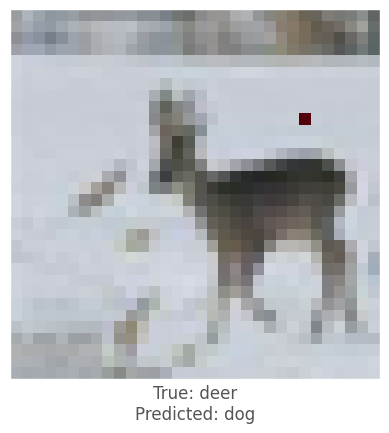

In [15]:
image_id = 20
pixels = 1 # Number of pixels to attack
# model = lenet
model = resnet
# model = net_in_net
# model = densenet

_ = attack(image_id, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

In the targeted attack, we can choose which class we want a model to classify an image as. The task is much harder for the targeted attack, as we constrain the misclassification to a given class rather than any class that's not the correct one. We should see the confidence in the target class rise after several iterations.

Below we try to cause the `lenet` to classify an image of a `ship` as an `automobile`. Try to change the parameters and see what happens.

Attacking with target automobile
1
Confidence: 9.497087e-06
Confidence: 9.497087e-06
Confidence: 9.497087e-06
Confidence: 9.497087e-06
Confidence: 9.497087e-06
Confidence: 1.55379e-05
Confidence: 1.55379e-05
Confidence: 1.55379e-05
Confidence: 1.55379e-05
Confidence: 1.55379e-05
Confidence: 1.55379e-05
Confidence: 5.132738e-05
Confidence: 5.132738e-05
Confidence: 5.132738e-05
Confidence: 5.948104e-05
Confidence: 5.948104e-05
Confidence: 5.948104e-05
Confidence: 5.948104e-05
Confidence: 5.948104e-05
Confidence: 5.948104e-05
Confidence: 5.948104e-05
Confidence: 0.0001916865
Confidence: 0.0001916865
Confidence: 0.0001916865
Confidence: 0.0001916865
Confidence: 0.0001916865
Confidence: 0.0001916865
Confidence: 0.0001916865
Confidence: 0.0001916865
Confidence: 0.00025043736
Confidence: 0.00025043736
Confidence: 0.00025043736
Confidence: 0.00025043736
Confidence: 0.00025043736
Confidence: 0.00025043736
Confidence: 0.00025043736
Confidence: 0.00025043736
Confidence: 0.00025043736
Confidence: 

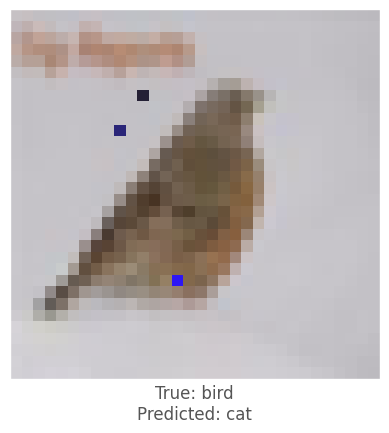

In [17]:
image_id = 108
target_class = 1 # Integer in range 0-9
pixels = 3
model = resnet

print('Attacking with target', class_names[target_class])
_ = attack(image_id, model, target_class, pixel_count=pixels, verbose=True)

### Collect Results

Armed with all the necessary tools to conduct a one pixel attack, the final step is to collect relevant statistics on the targeted and untargeted attack. The relevant data points are what percentage of images were we able to successfully attack for a given model, and how the number of pixels affect this percentage.

We will loop through every combination of all models, perturbations of 1,3,5 pixels, images, and target classes (for the targeted attack). This will take a lot of computational resources and time, so [skip to the statistics section](#Attack-Statistics) if that's not your idea of fun.

In [ ]:
imgpath = './images/resnet_sample/'
attackPath = os.path.join(imgpath, 'attack/')
originPath = os.path.join(imgpath, 'original/')

def attack_all(models, samples=500, pixels=(1,3,5), targeted=False, maxiter=75, popsize=400, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples, replace=False)
        
        for pixel_count in pixels:
            for i, img_id in enumerate(img_samples):
                print('\n', model.name, '- image', img_id, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if targeted:
                        print('Attacking with target', class_names[target])
                        if target == y_train[img_id, 0]:
                            continue
                    result = attack(img_id, model, target, pixel_count, 
                                maxiter, popsize, verbose, attack_img=True)
                    
                    orginal_img = Image.fromarray(x_train[img_id])
                    orginal_img.save(originPath+str(img_id)+"_"+str(class_names[y_train[img_id, 0]])+'.png')
                    
                    attack_img = Image.fromarray(result[10])
                    attack_img.save(attackPath+str(img_id)+"_"+str(class_names[y_train[img_id, 0]])+'.png')
                    model_results.append(result[:-1])
                    
        results += model_results
        helper.checkpoint(results, targeted)
    return results

In [ ]:
untargeted = attack_all(models, maxiter=30, targeted=False)

In [ ]:
targeted = attack_all(models, samples=10, targeted=True)

### Attack Statistics

Print the final results! 

In [ ]:
# Load the results
untargeted, targeted = helper.load_results()

In [ ]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [ ]:
helper.attack_stats(untargeted_results, models, network_stats)

#### Targeted

In [ ]:
helper.attack_stats(targeted_results, models, network_stats)

### Show some successful attacks

Plot 9 random successful attack images

In [ ]:
print('Untargeted Attack')
helper.visualize_attack(untargeted_results, class_names)

In [ ]:
print('Targeted Attack')
helper.visualize_attack(targeted_results, class_names)

## Conclusions

It appears that the accuracy of a model is not strongly correlated with the chance of performing a successful attack on an image. Perhaps surprisingly, the purely convolutional model is the most resistant CNN to these types of attacks. In addition, the capsule network CapsNet has the lowest attack success rate out of all the models, although it is still vulnerable to attack.

[Part 2](1_one-pixel-attack-cifar10.ipynb)

## Credits
 -  This implemenation is based off of the original paper describing the one pixel attack: https://arxiv.org/abs/1710.08864
 - Base code for iPython notebook: https://github.com/09rohanchopra/cifar10
 - Keras Cifar10 models: https://github.com/BIGBALLON/cifar-10-cnn
 - Scipy's differential evolution implementation: https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html
 - State of the art: https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems
 - CapsNet Keras: https://github.com/XifengGuo/CapsNet-Keras
 - CapsNet with Cifar: https://github.com/theblackcat102/dynamic-routing-capsule-cifar